# MIS 382N -- Advanced Machine Learning Term Project Code
## Written By: Scott Stempak, Mason Shu, Theresa Sushil, Gaurav Shukla, and Pratyush Rohilla

# **To see the code implemented for the models we used in our Medium Article, scroll down to header titled: "Code Implementation for the Models used in the Blog Post" at the bottom of this code**
#### You just need to run all function definitions and process videos to be able to run the models if you wish to rerun them

#### Link to medium article: https://medium.com/@sdstempak14/analyzing-surveillance-videos-to-detect-crime-aa337a7430f2

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets.folder import default_loader
from torchvision import transforms, models
from PIL import Image
import os
import re
import random
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def extract_frame_features(frame_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(frame_path).convert('RGB')
    return preprocess(image)

In [4]:
class ResNetFeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNetFeatureExtractor, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
    def forward(self, x):
        features = self.feature_extractor(x)
        return features.view(features.size(0), -1)

In [5]:
# Initialize feature extractor
feature_extractor = ResNetFeatureExtractor().to(device).eval()

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/scott/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 15.7MB/s]


In [6]:
class FrameDataset(Dataset):
    """
    Dataset for loading video frames and their labels.
    """
    def __init__(self, directory_path, category_label, regex_patterns):
        self.frame_files = []
        self.labels = []
        self.category_label = category_label
        for frame_file in sorted(os.listdir(directory_path)):
            for regex in regex_patterns:
                if regex.match(frame_file):
                    frame_path = os.path.join(directory_path, frame_file)
                    self.frame_files.append(frame_path)
                    self.labels.append(category_label)
                    break
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        frame_path = self.frame_files[idx]
        image = default_loader(frame_path).convert('RGB')
        return self.transform(image), self.labels[idx]

In [7]:
def count_videos(directory_path, regex_patterns):
    """
    Counts the number of unique videos in the given directory based on regex patterns.
    Args:
        directory_path: Path to the directory containing video frames.
        regex_patterns: List of regex patterns to match video names.
    Returns:
        Number of unique videos detected.
    """
    detected_videos = set()

    for frame_file in sorted(os.listdir(directory_path)):
        for regex in regex_patterns:
            match = regex.match(frame_file)
            if match:
                video_name = match.groups()[0]  # Extract video name
                detected_videos.add(video_name)
                break  # Stop checking other regex patterns for this file

    return len(detected_videos), detected_videos

In [8]:
def extract_video_name_from_frame(frame_path, regex_patterns):
    frame_file = os.path.basename(frame_path)
    for regex in regex_patterns:
        match = regex.match(frame_file)
        if match:
            return match.groups()[0]
    return None

In [9]:
# Example Usage
regex_patterns = [
    re.compile(r"([A-Za-z]+[0-9]+_x[0-9]+)_(\d+)\.png"),
    re.compile(r"([A-Za-z]+_[A-Za-z]+[0-9]+_x[0-9]+)_(\d+)\.png"),
    re.compile(r"([A-Za-z]+_[A-Za-z]+_[0-9]+_x[0-9]+)_(\d+)\.png")
]

In [10]:
def process_videos_with_batches(directory_path, category_label, regex_patterns, batch_size=32, video_limit=None):
    """
    Processes video frames in batches and aggregates features for each video.
    Args:
        directory_path: Path to the directory containing frames for the category.
        category_label: Binary label for the video category (0 for Normal, 1 for Crime).
        regex_patterns: List of regex patterns for matching frame file names.
        batch_size: Number of frames to process in a batch.
        video_limit: Maximum number of videos to process (for debugging or data limits).
    Returns:
        List of tuples [(video_features, label)], where video_features are aggregated frame features.
    """

    # Count videos before processing
    total_videos, detected_videos = count_videos(directory_path, regex_patterns)
    print(f"{total_videos} videos detected.")

    dataset = FrameDataset(directory_path, category_label, regex_patterns)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    data = []
    current_video_features = []
    current_video = None
    processed_videos = set()
    frame_count = 0

    for batch in dataloader:
        frames, labels = batch
        frames = frames.to(device)

        # Extract features for all frames in the batch
        with torch.no_grad():
            features = feature_extractor(frames)

        for i, feature in enumerate(features):
            frame_path = dataset.frame_files[frame_count]
            video_name = extract_video_name_from_frame(frame_path, regex_patterns)

            # If we encounter a new video
            if video_name != current_video:
                if current_video_features:
                    # Aggregate features for the completed video
                    data.append((torch.stack(current_video_features), category_label))
                    processed_videos.add(current_video)
                    if len(processed_videos) % 25 == 0:
                        print(f'processed video {len(processed_videos)}')

                    # Stop if the video limit is reached
                    if video_limit and len(processed_videos) >= video_limit:
                        print(f"Processed {len(processed_videos)} videos, {frame_count} frames in total.")
                        return data

                # Start processing the new video
                current_video_features = []
                current_video = video_name

            # Add the current frame's features
            current_video_features.append(feature.squeeze(0))
            frame_count += 1

    # Handle the last video
    if current_video_features:
        data.append((torch.stack(current_video_features), category_label))
        processed_videos.add(current_video)

    print(f"Processed {len(processed_videos)} videos, {frame_count} frames in total.")
    return data

In [11]:
class TemporalVideoDataset(Dataset):
    """
    Custom Dataset for video-level features extracted and aggregated.
    """
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        features, label = self.data[idx]
        return features, torch.tensor(label, dtype=torch.long), features.size(0)  # Include sequence length

In [12]:
def collate_fn(batch):
    features, labels, lengths = zip(*batch)
    max_length = min(max(lengths), 512)  # Set a reasonable max sequence length (e.g., 512)

    # Create padded features
    padded_features = [
        torch.cat([f[:max_length], torch.zeros(max(max_length - f.size(0), 0), f.size(1))], dim=0)
        for f in features
    ]
    padded_features = torch.stack(padded_features)

    # Create padding masks
    masks = torch.arange(max_length).expand(len(batch), max_length).to(device) >= torch.tensor(lengths).unsqueeze(1).to(device)

    labels = torch.tensor(labels, dtype=torch.long)
    lengths = torch.tensor([min(l, max_length) for l in lengths], dtype=torch.long)

    return padded_features, labels, lengths, masks

In [13]:
#Causal Transformer for Temporal Modeling
class CausalTransformer(nn.Module):
    """
    Temporal model for binary classification (Normal vs. Crime).
    """
    def __init__(self, input_dim, num_heads, num_layers, dropout=0.1):
        super(CausalTransformer, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(input_dim, 2)  # Binary classification

    def forward(self, x, lengths):
        batch_size, seq_len, _ = x.size()
        mask = torch.arange(seq_len).expand(batch_size, seq_len).to(x.device) >= lengths.unsqueeze(1)
        x = self.transformer(x, src_key_padding_mask=mask)
        return self.classifier(x[:, -1, :])  # Output logits for two classes

In [14]:
def train_with_validation(
    train_dataloader, val_dataloader, model, criterion, optimizer, device, num_epochs=10, patience=3
):
    """
    Train the model with validation and early stopping.
    Args:
        train_dataloader: DataLoader for the training set.
        val_dataloader: DataLoader for the validation set.
        model: The model to train.
        criterion: Loss function.
        optimizer: Optimizer for training.
        device: Device to run the model on.
        num_epochs: Maximum number of epochs to train.
        patience: Number of epochs to wait for validation improvement (early stopping).
    """
    best_val_loss = float('inf')  # Initialize the best validation loss
    patience_counter = 0  # Counter for early stopping
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        for features, labels, lengths, masks in train_dataloader:
            features, labels, lengths, masks = (
                features.to(device),
                labels.to(device),
                lengths.to(device),
                masks.to(device),
            )
            optimizer.zero_grad()
            outputs = model(features, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")
        # Validation phase
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for features, labels, lengths, masks in val_dataloader:
                features, labels, lengths, masks = (
                    features.to(device),
                    labels.to(device),
                    lengths.to(device),
                    masks.to(device),
                )
                outputs = model(features, lengths)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_dataloader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}")
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), "best_model.pth")
            print("Validation loss improved. Saving the model...")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

In [15]:
def save_model(model, file_path):
    """
    Save the trained model to a file.
    Args:
        model: The trained model to save.
        file_path: The file path to save the model to.
    """
    torch.save(model.state_dict(), file_path)
    print(f"Model saved to {file_path}")

In [16]:
def process_crime_videos(crime_labels, base_directory, output_directory, regex_patterns, process_function):
    """
    Processes videos for multiple crime types, saves the results to pickle files, and returns a dictionary of processed data.
    Args:
        crime_labels: Dictionary mapping crime types (keys) to unique labels (values).
        base_directory: Base directory containing crime type subdirectories (e.g., "Dataset/Train").
        regex_patterns: List of regex patterns to match video frame filenames.
        process_function: Function used for processing videos (e.g., process_videos_with_batches).
    Returns:
        Dictionary of processed data with crime types as keys.
    """

    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    crime_label_data = {}
    for crime_type, label in crime_labels.items():
        # Construct the directory path dynamically
        directory_path = f"{base_directory}/{crime_type}"
        # Process videos for the current crime type
        print(f"Processing videos for crime type: {crime_type} (Label={label})")
        crime_data = process_function(
            directory_path=directory_path,
            category_label=label,
            regex_patterns=regex_patterns,
        )
        # Dynamically store the data in a dictionary with crime type as the key
        crime_label_data[crime_type] = crime_data
        # Save the processed data to a pickle file
        pickle_file_path = f"{output_directory}/{crime_type.lower()}_data.pkl"
        with open(pickle_file_path, "wb") as pickle_file:
            pickle.dump(crime_data, pickle_file)
            print(f"Saved {crime_type} data to {pickle_file_path}")
    return crime_label_data

In [17]:
crime_labels = {
    'Abuse': 1,
    'Arrest': 2,
    'Arson': 3,
    'Assault': 4,
    'Burglary': 5,
    'Explosion': 6,
    'Fighting': 7,
    'RoadAccidents': 8,
    'Robbery': 9,
    'Shooting': 10,
    'Shoplifting': 11,
    'Stealing': 12,
    'Vandalism': 13,
}

train_directory = 'Dataset/Train'
test_directory = 'Dataset/Test'

train_output_directory = 'ProcessedData/Train'
test_output_directory = 'ProcessedData/Test'

In [ ]:
# Process training crime videos
train_crime_data = process_crime_videos(
    crime_labels=crime_labels,
    base_directory=train_directory,
    output_directory=train_output_directory,
    regex_patterns=regex_patterns,
    process_function=process_videos_with_batches
)

In [ ]:
# Process test crime videos
test_crime_data = process_crime_videos(
    crime_labels=crime_labels,
    base_directory=test_directory,
    output_directory=test_output_directory,
    regex_patterns=regex_patterns,
    process_function=process_videos_with_batches  # Replace with your processing function
)

Processing videos for crime type: Abuse (Label=1)
2 videos detected.
Processed 2 videos, 297 frames in total.
Saved Abuse data to abuse_data.pkl
Processing videos for crime type: Arrest (Label=2)
5 videos detected.
Processed 5 videos, 3365 frames in total.
Saved Arrest data to arrest_data.pkl
Processing videos for crime type: Arson (Label=3)
9 videos detected.
Processed 9 videos, 2793 frames in total.
Saved Arson data to arson_data.pkl
Processing videos for crime type: Assault (Label=4)
3 videos detected.
Processed 3 videos, 2657 frames in total.
Saved Assault data to assault_data.pkl
Processing videos for crime type: Burglary (Label=5)
13 videos detected.
Processed 13 videos, 7657 frames in total.
Saved Burglary data to burglary_data.pkl
Processing videos for crime type: Explosion (Label=6)
21 videos detected.
Processed 21 videos, 6510 frames in total.
Saved Explosion data to explosion_data.pkl
Processing videos for crime type: Fighting (Label=7)
5 videos detected.
Processed 5 videos,

In [ ]:
normal_data = process_videos_with_batches('Dataset/Train/NormalVideos', 0, regex_patterns)

#### Use if loading from pickle file (uncomment last two lines)

In [ ]:
# # Combine data
# # Convert back to the original format if needed
# # Assuming process_videos_with_temporal_context returns numpy arrays or lists
# normal_data = pd.read_pickle("normal_data.pkl")
# normal_data = normal_data.to_numpy()

In [ ]:
def merge_crime_labels(data, crime_labels):
    """
    Convert multiple crime category labels into a single 'crime' label.
    Args:
        data: List of tuples [(video_features, label, ...)].
        crime_labels: Set of labels representing the 13 crime types.
    Returns:
        Updated dataset with merged crime labels (0 for Normal, 1 for Crime).
    """
    merged_data = []
    for entry in data:
        # Unpack the tuple dynamically based on its length
        video_features, label = entry
        # Convert label to binary: 1 if it's a crime, otherwise 0
        new_label = 1 if label in crime_labels else 0
        merged_data.append((video_features, new_label))
    return merged_data

#### Test runs

In [ ]:
# Dynamically generate crime labels (1 through 13)
crime_labels = set(range(1, 14))  # {1, 2, 3, ..., 13}
# Combine all processed crime data into a single list
all_train_crime_data = []
for crime_type, data in train_crime_data.items():
    all_train_crime_data.extend(data)  # Append data for each crime type
# Merge all crime labels into one class (1 for Crime, 0 for Normal)
train_binary_crime_data = merge_crime_labels(all_train_crime_data, crime_labels)

In [ ]:
# Dynamically generate crime labels (1 through 13)
crime_labels = set(range(1, 14))  # {1, 2, 3, ..., 13}
# Combine all processed crime data into a single list
all_test_crime_data = []
for crime_type, data in test_crime_data.items():
    all_test_crime_data.extend(data)  # Append data for each crime type
# Merge all crime labels into one class (1 for Crime, 0 for Normal)
test_binary_crime_data = merge_crime_labels(all_test_crime_data, crime_labels)

In [22]:
def load_crime_data_from_directory(directory):
    """
    Load all pickle files from the given directory and save them as variables.
    Args:
        directory: Path to the directory containing the pickle files.
    Returns:
        A dictionary with variable names (crime types) as keys and loaded data as values.
    """
    crime_data = {}
    # Loop through all files in the directory
    for file in os.listdir(directory):
        if file.endswith(".pkl"):  # Only process pickle files
            # Extract the variable name from the file name
            variable_name = file.replace("_data.pkl", "")
            # Load the pickle file
            file_path = os.path.join(directory, file)
            print(f"Loading {file_path}...")
            crime_data[variable_name] = pd.read_pickle(file_path)
    return crime_data

In [23]:
# Directory containing the pickle files
train_directory = "ProcessedData/Train"
# Load all training crime data
train_crime_data = load_crime_data_from_directory(train_directory)
# Assign each crime type to its respective variable
abuse_data = train_crime_data["abuse"]
arrest_data = train_crime_data["arrest"]
arson_data = train_crime_data["arson"]
assault_data = train_crime_data["assault"]
burglary_data = train_crime_data["burglary"]
explosion_data = train_crime_data["explosion"]
fighting_data = train_crime_data["fighting"]
roadaccidents_data = train_crime_data["roadaccidents"]
robbery_data = train_crime_data["robbery"]
shooting_data = train_crime_data["shooting"]
shoplifting_data = train_crime_data["shoplifting"]
stealing_data = train_crime_data["stealing"]
vandalism_data = train_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(train_crime_data)} crime types:")

Loading ProcessedData/Train\abuse_data.pkl...
Loading ProcessedData/Train\arrest_data.pkl...
Loading ProcessedData/Train\arson_data.pkl...
Loading ProcessedData/Train\assault_data.pkl...
Loading ProcessedData/Train\burglary_data.pkl...
Loading ProcessedData/Train\explosion_data.pkl...
Loading ProcessedData/Train\fighting_data.pkl...
Loading ProcessedData/Train\roadaccidents_data.pkl...
Loading ProcessedData/Train\robbery_data.pkl...
Loading ProcessedData/Train\shooting_data.pkl...
Loading ProcessedData/Train\shoplifting_data.pkl...
Loading ProcessedData/Train\stealing_data.pkl...
Loading ProcessedData/Train\vandalism_data.pkl...
Loaded 13 crime types:


In [24]:
# Combine all crime data into one list
all_train_crime_data = []
for crime_data in [
    abuse_data, arrest_data, arson_data, assault_data, burglary_data,
    explosion_data, fighting_data, roadaccidents_data, robbery_data,
    shooting_data, shoplifting_data, stealing_data, vandalism_data
]:
    all_train_crime_data.extend(crime_data)
# Dynamically generate crime labels (1 through 13)
crime_labels = set(range(1, 14))  # {1, 2, 3, ..., 13}
# Merge all crime labels into one class (1 for Crime, 0 for Normal)
train_binary_crime_data = merge_crime_labels(all_train_crime_data, crime_labels)

In [25]:
print(type(train_binary_crime_data))
print(type(normal_data))

<class 'list'>
<class 'numpy.ndarray'>


In [26]:
normal_data = pd.read_pickle("normal_data.pkl")
normal_data = normal_data.to_numpy()
normal_data = normal_data.tolist()

In [27]:
training_data = train_binary_crime_data + normal_data

In [28]:
# # Combine Normal and oversampled Crime data
# balanced_training_data = np.concatenate([normal_data, oversampled_crime_data], axis=0)
# random.shuffle(balanced_training_data)  # Shuffle the data for randomness
# # Create a dataset and DataLoader for the balanced training data
from sklearn.model_selection import train_test_split
# # Assuming `training_data` contains your full training dataset
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
# Print sizes for verification
print(f"Training set size: {len(train_data)}, Validation set size: {len(val_data)}")

train_dataset = TemporalVideoDataset(training_data)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
# Create DataLoader for the validation set
val_dataset = TemporalVideoDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

Training set size: 1288, Validation set size: 322


In [29]:
# Check the balanced class distribution
print(f"Number of training batches: {len(train_dataloader)}")

Number of training batches: 101


In [30]:
# Initialize causal transformer
model = CausalTransformer(input_dim=512, num_heads=4, num_layers=4).to(device)  # Reduce complexity
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# train_with_validation(
#     train_dataloader=train_dataloader,
#     val_dataloader=val_dataloader,
#     model=model,
#     criterion=criterion,
#     optimizer=optimizer,
#     device=device,
#     num_epochs=20,  # Set a higher max epoch since early stopping will stop it early
#     patience=5  # Adjust patience based on your dataset
# )

# # # Train model
# # epoch_model_losses = train_model(train_dataloader, model, criterion, optimizer, device, num_epochs=10)

Epoch 1/20, Training Loss: 0.5508
Epoch 1/20, Validation Loss: 0.5909
Validation loss improved. Saving the model...
Epoch 2/20, Training Loss: 0.4042
Epoch 2/20, Validation Loss: 0.5732
Validation loss improved. Saving the model...
Epoch 3/20, Training Loss: 0.2898
Epoch 3/20, Validation Loss: 0.5456
Validation loss improved. Saving the model...
Epoch 4/20, Training Loss: 0.2269
Epoch 4/20, Validation Loss: 0.6083
Validation loss did not improve. Patience: 1/5
Epoch 5/20, Training Loss: 0.1542
Epoch 5/20, Validation Loss: 0.5296
Validation loss improved. Saving the model...
Epoch 6/20, Training Loss: 0.1189
Epoch 6/20, Validation Loss: 0.5294
Validation loss improved. Saving the model...
Epoch 7/20, Training Loss: 0.0989
Epoch 7/20, Validation Loss: 0.5202
Validation loss improved. Saving the model...
Epoch 8/20, Training Loss: 0.0364
Epoch 8/20, Validation Loss: 0.5138
Validation loss improved. Saving the model...
Epoch 9/20, Training Loss: 0.0385
Epoch 9/20, Validation Loss: 0.5280
V

In [31]:
# **3. Causal Transformer for Temporal Modeling**
class CausalTransformerMultiClass(nn.Module):
    """
    Temporal model for Multi-Class classification (Normal and Different Crime Types).
    """
    def __init__(self, input_dim, num_heads, num_layers, dropout=0.1):
        super(CausalTransformerMultiClass, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(input_dim, 14)  # Binary classification
    def forward(self, x, lengths):
        batch_size, seq_len, _ = x.size()
        mask = torch.arange(seq_len).expand(batch_size, seq_len).to(x.device) >= lengths.unsqueeze(1)
        x = self.transformer(x, src_key_padding_mask=mask)
        return self.classifier(x[:, -1, :])  # Output logits for two classes

In [ ]:
from sklearn.model_selection import train_test_split
# Ensure the Models directory exists
os.makedirs("ModelsMultiClass", exist_ok=True)
# List of batch sizes to try
batch_sizes = [2, 8, 16]
# Loop through each batch size
for current_batch_size in batch_sizes:
    print(f"Training with batch size: {current_batch_size}")
    train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
    train_dataset = TemporalVideoDataset(training_data)
    val_dataset = TemporalVideoDataset(val_data)
    # Update dataloaders with the current batch size
    train_dataloader = DataLoader(train_dataset, batch_size=current_batch_size, shuffle=True, collate_fn=collate_fn)
    val_dataloader = DataLoader(val_dataset, batch_size=current_batch_size, shuffle=False, collate_fn=collate_fn)
    # 3. Combine Feature Extractor and Classifier
    model = CausalTransformerMultiClass(input_dim=512, num_heads=4, num_layers=4).to(device)  # Reduce complexity
    # 4. Define Optimizer
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    # 5. Define Criterion
    criterion = nn.CrossEntropyLoss()
    # 6. Train the Model
    train_with_validation(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20,  # Set a higher max epoch since early stopping will stop it early
    patience=5  # Adjust patience based on your dataset
)
    # 7. Save the Model
    file_path = f"ModelsMultiClass/batch_size_{current_batch_size}.pth"
    save_model(model, file_path)
    print(f"Model with batch size {current_batch_size} saved to {file_path}")

In [33]:
def load_model(model, file_path, device):
    """
    Load a saved model from a file.
    Args:
        model: The model architecture to load the weights into.
        file_path: The file path to load the model from.
        device: The device to load the model onto (CPU or GPU).
    Returns:
        The model with loaded weights.
    """
    model.load_state_dict(torch.load(file_path, map_location=device))
    model.to(device)
    print(f"Model loaded from {file_path}")
    return model

In [34]:
# Directory containing the pickle files
test_directory = "ProcessedData/Test"
# Load all training crime data
test_crime_data = load_crime_data_from_directory(test_directory)
# Assign each crime type to its respective variable
test_abuse_data = test_crime_data["abuse"]
test_arrest_data = test_crime_data["arrest"]
test_arson_data = test_crime_data["arson"]
test_assault_data = test_crime_data["assault"]
test_burglary_data = test_crime_data["burglary"]
test_explosion_data = test_crime_data["explosion"]
test_fighting_data = test_crime_data["fighting"]
test_roadaccidents_data = test_crime_data["roadaccidents"]
test_robbery_data = test_crime_data["robbery"]
test_shooting_data = test_crime_data["shooting"]
test_shoplifting_data = test_crime_data["shoplifting"]
test_stealing_data = test_crime_data["stealing"]
test_vandalism_data = test_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(test_crime_data)} crime types:")

Loading ProcessedData/Test\abuse_data.pkl...
Loading ProcessedData/Test\arrest_data.pkl...
Loading ProcessedData/Test\arson_data.pkl...
Loading ProcessedData/Test\assault_data.pkl...
Loading ProcessedData/Test\burglary_data.pkl...
Loading ProcessedData/Test\explosion_data.pkl...
Loading ProcessedData/Test\fighting_data.pkl...
Loading ProcessedData/Test\roadaccidents_data.pkl...
Loading ProcessedData/Test\robbery_data.pkl...
Loading ProcessedData/Test\shooting_data.pkl...
Loading ProcessedData/Test\shoplifting_data.pkl...
Loading ProcessedData/Test\stealing_data.pkl...
Loading ProcessedData/Test\vandalism_data.pkl...
Loaded 13 crime types:


In [35]:
# Combine all crime data into one list
all_test_crime_data = []
for crime_data in [
    test_abuse_data, test_arrest_data, test_arson_data, test_assault_data, test_burglary_data,
    test_explosion_data, test_fighting_data, test_roadaccidents_data, test_robbery_data,
    test_shooting_data, test_shoplifting_data, test_stealing_data, test_vandalism_data
]:
    all_test_crime_data.extend(crime_data)
# Dynamically generate crime labels (1 through 13)
crime_labels = set(range(1, 14))  # {1, 2, 3, ..., 13}
# Merge all crime labels into one class (1 for Crime, 0 for Normal)
test_binary_crime_data = merge_crime_labels(all_test_crime_data, crime_labels)

In [36]:
test_normal_data = pd.read_pickle("normal_test_data.pkl")
test_normal_data = test_normal_data.to_numpy()
test_normal_data = test_normal_data.tolist()
test_data = test_normal_data + test_binary_crime_data

In [37]:
print(type(test_binary_crime_data))
print(type(test_normal_data))

<class 'list'>
<class 'list'>


In [ ]:
def predict_with_threshold(outputs, threshold=0.5):
    """
    Adjust decision threshold for classification.
    Args:
        outputs: Model outputs (logits or probabilities).
        threshold: Decision threshold for the Crime class.
    Returns:
        Predicted labels.
    """
    probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
    predictions = (probabilities[:, 1] > threshold).long()  # Compare Crime probability to threshold
    return predictions

In [39]:
def evaluate_model(model, dataloader, device, threshold=0.5):
    """
    Evaluate the model on the given dataloader using a custom threshold and return probabilities.
    Args:
        model: The trained model.
        dataloader: DataLoader for the evaluation dataset.
        device: Device to run the model on (CPU or GPU).
        threshold: Decision threshold for the Crime class.
    Returns:
        predictions: List of predicted labels.
        true_labels: List of true labels.
        probabilities: List of probabilities for the Crime class.
    """
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []  # Store probabilities for the Crime class
    with torch.no_grad():
        for features, labels, lengths, masks in dataloader:  # Unpack all four values
            features, labels, lengths, masks = (
                features.to(device),
                labels.to(device),
                lengths.to(device),
                masks.to(device),
            )
            outputs = model(features, lengths)  # Ensure the model's forward method handles masks
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for the Crime class
            predicted_labels = (probs > threshold).long()  # Threshold-based predictions
            predictions.extend(predicted_labels.cpu().tolist())
            true_labels.extend(labels.cpu().tolist())
            probabilities.extend(probs.cpu().tolist())  # Append probabilities for ROC-AUC
    return predictions, true_labels, probabilities

In [ ]:
def compute_metrics(predictions, true_labels, probabilities=None):
    """
    Computes evaluation metrics for binary classification and displays the ROC-AUC curve.
    Args:
        predictions: Predicted labels (0 or 1).
        true_labels: True labels (0 or 1).
        probabilities: Predicted probabilities for the positive class (Crime). Required for ROC-AUC.
    """
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:\n", cm)
    # Classification report
    report = classification_report(true_labels, predictions, target_names=["Normal", "Crime"])
    print("\nClassification Report:\n", report)
    # Plot ROC-AUC curve if probabilities are provided
    if probabilities is not None:
        fpr, tpr, _ = roc_curve(true_labels, probabilities)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic (ROC) Curve")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()
    else:
        print("\nROC-AUC Curve not plotted. Provide predicted probabilities to display the ROC curve.")

In [45]:
def evaluate_model_multiclass(model, dataloader, device):
    """
    Evaluate the model on the given dataloader for multi-class classification.
    Args:
        model: The trained model.
        dataloader: DataLoader for the evaluation dataset.
        device: Device to run the model on (CPU or GPU).
    Returns:
        predictions: List of predicted class labels.
        true_labels: List of true class labels.
        probabilities: List of predicted probabilities for each class.
    """
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    with torch.no_grad():
        for features, labels, lengths, masks in dataloader:  # Unpack all values
            features, labels, lengths, masks = (
                features.to(device),
                labels.to(device),
                lengths.to(device),
                masks.to(device),
            )
            outputs = model(features, lengths)  # Forward pass
            prob = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            predicted_labels = torch.argmax(prob, dim=1)  # Get predicted class
            # Collect results
            probabilities.extend(prob.cpu().tolist())  # Store probabilities
            predictions.extend(predicted_labels.cpu().tolist())  # Store predicted labels
            true_labels.extend(labels.cpu().tolist())  # Store true labels
    return predictions, true_labels, probabilities

def compute_metrics_multiclass(predictions, true_labels, probabilities=None, num_classes=14, class_to_category=None):
    """
    Computes evaluation metrics for multi-class classification and plots the ROC-AUC curve for each class.
    Args:
        predictions: Predicted labels.
        true_labels: True labels.
        probabilities: Predicted probabilities for each class.
        num_classes: Number of classes in the classification task.
        class_to_category: Dictionary mapping class indices to category names.
    """
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    if class_to_category:
        target_names = [class_to_category[i] for i in range(num_classes)]
    else:
        target_names = [f"Class {i}" for i in range(num_classes)]
    report = classification_report(true_labels, predictions, target_names=target_names)
    print("\nClassification Report:\n", report)

    # ROC-AUC and ROC Curves
    if probabilities is not None:
        # One-vs-Rest (OvR) calculation for multi-class ROC-AUC
        true_labels_one_hot = np.eye(num_classes)[true_labels]  # Convert labels to one-hot encoding
        roc_auc_scores = {}
        plt.figure(figsize=(10, 8))
        for i in range(num_classes):
            # Compute ROC curve and ROC area for each class
            fpr, tpr, _ = roc_curve(true_labels_one_hot[:, i], np.array(probabilities)[:, i])
            roc_auc = roc_auc_score(true_labels_one_hot[:, i], np.array(probabilities)[:, i])
            if class_to_category:
                class_label = class_to_category[i]
            else:
                class_label = f"Class {i}"
            roc_auc_scores[class_label] = roc_auc
            # Plot ROC curve for this class
            plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.2f})")

        # Plot formatting
        plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC-AUC Curve for Multi-Class Classification")
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

        # Print ROC-AUC scores for each class
        for class_name, roc_auc in roc_auc_scores.items():
            print(f"{class_name}: ROC-AUC = {roc_auc:.4f}")


# Code Implementation for the Models used in the Blog Post

## https://medium.com/@sdstempak14/analyzing-surveillance-videos-to-detect-crime-aa337a7430f2

## Regular Binary Model

Loading ProcessedData/Train\abuse_data.pkl...
Loading ProcessedData/Train\arrest_data.pkl...
Loading ProcessedData/Train\arson_data.pkl...
Loading ProcessedData/Train\assault_data.pkl...
Loading ProcessedData/Train\burglary_data.pkl...
Loading ProcessedData/Train\explosion_data.pkl...
Loading ProcessedData/Train\fighting_data.pkl...
Loading ProcessedData/Train\roadaccidents_data.pkl...
Loading ProcessedData/Train\robbery_data.pkl...
Loading ProcessedData/Train\shooting_data.pkl...
Loading ProcessedData/Train\shoplifting_data.pkl...
Loading ProcessedData/Train\stealing_data.pkl...
Loading ProcessedData/Train\vandalism_data.pkl...
Loaded 13 crime types:
Training set size: 1288, Validation set size: 322
Epoch 1/20, Training Loss: 0.5659
Epoch 1/20, Validation Loss: 0.6192
Validation loss improved. Saving the model...
Epoch 2/20, Training Loss: 0.4025
Epoch 2/20, Validation Loss: 0.6326
Validation loss did not improve. Patience: 1/5
Epoch 3/20, Training Loss: 0.2933
Epoch 3/20, Validation 

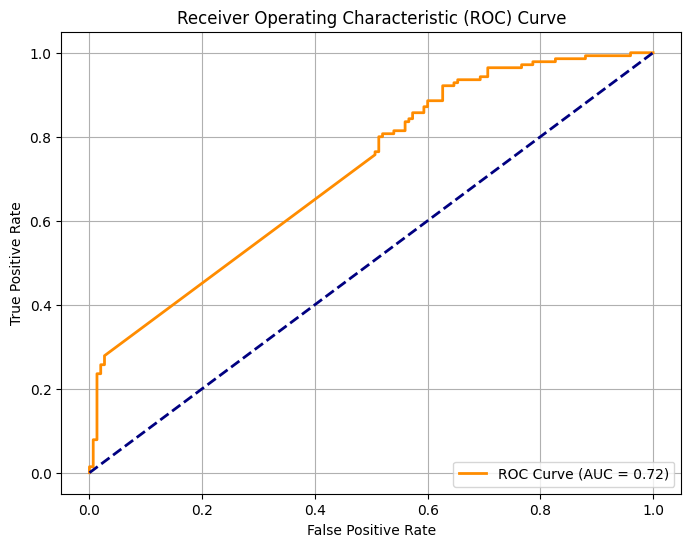

In [60]:
# Directory containing the pickle files
train_directory = "ProcessedData/Train"
# Load all training crime data
train_crime_data = load_crime_data_from_directory(train_directory)
# Assign each crime type to its respective variable
abuse_data = train_crime_data["abuse"]
arrest_data = train_crime_data["arrest"]
arson_data = train_crime_data["arson"]
assault_data = train_crime_data["assault"]
burglary_data = train_crime_data["burglary"]
explosion_data = train_crime_data["explosion"]
fighting_data = train_crime_data["fighting"]
roadaccidents_data = train_crime_data["roadaccidents"]
robbery_data = train_crime_data["robbery"]
shooting_data = train_crime_data["shooting"]
shoplifting_data = train_crime_data["shoplifting"]
stealing_data = train_crime_data["stealing"]
vandalism_data = train_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(train_crime_data)} crime types:")


# Combine all crime data into one list
all_train_crime_data = []
for crime_data in [
    abuse_data, arrest_data, arson_data, assault_data, burglary_data,
    explosion_data, fighting_data, roadaccidents_data, robbery_data,
    shooting_data, shoplifting_data, stealing_data, vandalism_data
]:
    all_train_crime_data.extend(crime_data)
# Dynamically generate crime labels (1 through 13)
crime_labels = set(range(1, 14))  # {1, 2, 3, ..., 13}
# Merge all crime labels into one class (1 for Crime, 0 for Normal)
train_binary_crime_data = merge_crime_labels(all_train_crime_data, crime_labels)

normal_data = pd.read_pickle("normal_data.pkl")
normal_data = normal_data.to_numpy()
normal_data = normal_data.tolist()

training_data = train_binary_crime_data + normal_data


# # Combine Normal and oversampled Crime data
# balanced_training_data = np.concatenate([normal_data, oversampled_crime_data], axis=0)
# random.shuffle(balanced_training_data)  # Shuffle the data for randomness
# # Create a dataset and DataLoader for the balanced training data
from sklearn.model_selection import train_test_split
# # Assuming `training_data` contains your full training dataset
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
# Print sizes for verification
print(f"Training set size: {len(train_data)}, Validation set size: {len(val_data)}")

train_dataset = TemporalVideoDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
# Create DataLoader for the validation set
val_dataset = TemporalVideoDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


# Binary Classification Model
model_binary_batch_2 = CausalTransformer(input_dim=512, num_heads=4, num_layers=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_binary_batch_2.parameters(), lr=1e-4)



train_with_validation(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model=model_binary_batch_2,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20,  # Set a higher max epoch since early stopping will stop it early
    patience=5  # Adjust patience based on your dataset
)

file_path = f"Models/regular_binary_batch_size_2.pth"
save_model(model_binary_batch_2, file_path)
print(f"Regular Binary model with batch size 2 saved.")

# Directory containing the pickle files
test_directory = "ProcessedData/Test"
# Load all training crime data
test_crime_data = load_crime_data_from_directory(test_directory)
# Assign each crime type to its respective variable
test_abuse_data = test_crime_data["abuse"]
test_arrest_data = test_crime_data["arrest"]
test_arson_data = test_crime_data["arson"]
test_assault_data = test_crime_data["assault"]
test_burglary_data = test_crime_data["burglary"]
test_explosion_data = test_crime_data["explosion"]
test_fighting_data = test_crime_data["fighting"]
test_roadaccidents_data = test_crime_data["roadaccidents"]
test_robbery_data = test_crime_data["robbery"]
test_shooting_data = test_crime_data["shooting"]
test_shoplifting_data = test_crime_data["shoplifting"]
test_stealing_data = test_crime_data["stealing"]
test_vandalism_data = test_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(test_crime_data)} crime types:")

# Combine all crime data into one list
all_test_crime_data = []
for crime_data in [
    test_abuse_data, test_arrest_data, test_arson_data, test_assault_data, test_burglary_data,
    test_explosion_data, test_fighting_data, test_roadaccidents_data, test_robbery_data,
    test_shooting_data, test_shoplifting_data, test_stealing_data, test_vandalism_data
]:
    all_test_crime_data.extend(crime_data)
# Dynamically generate crime labels (1 through 13)
crime_labels = set(range(1, 14))  # {1, 2, 3, ..., 13}
# Merge all crime labels into one class (1 for Crime, 0 for Normal)
test_binary_crime_data = merge_crime_labels(all_test_crime_data, crime_labels)

test_normal_data = pd.read_pickle("normal_test_data.pkl")
test_normal_data = test_normal_data.to_numpy()
test_normal_data = test_normal_data.tolist()
test_data = test_normal_data + test_binary_crime_data

# Create dataset and dataloader 
test_dataset = TemporalVideoDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

predictions_2, true_labels_2, probabilities_2 = evaluate_model(model_binary_batch_2, test_dataloader, device, threshold=0.5)
compute_metrics(predictions_2, true_labels_2, probabilities_2)

predictions_2, true_labels_2, probabilities_2 = evaluate_model(model_binary_batch_2, test_dataloader, device, threshold=0.55)
predictions_2, true_labels_2, probabilities_2 = evaluate_model(model_binary_batch_2, test_dataloader, device, threshold=0.6)

## Weighted Binary Model

Loading ProcessedData/Train\abuse_data.pkl...
Loading ProcessedData/Train\arrest_data.pkl...
Loading ProcessedData/Train\arson_data.pkl...
Loading ProcessedData/Train\assault_data.pkl...
Loading ProcessedData/Train\burglary_data.pkl...
Loading ProcessedData/Train\explosion_data.pkl...
Loading ProcessedData/Train\fighting_data.pkl...
Loading ProcessedData/Train\roadaccidents_data.pkl...
Loading ProcessedData/Train\robbery_data.pkl...
Loading ProcessedData/Train\shooting_data.pkl...
Loading ProcessedData/Train\shoplifting_data.pkl...
Loading ProcessedData/Train\stealing_data.pkl...
Loading ProcessedData/Train\vandalism_data.pkl...
Loaded 13 crime types:
Training set size: 1288, Validation set size: 322
Class Counts: Counter({1: 810, 0: 800})
Class Weights: {1: 1.9876543209876543, 0: 2.0125}
Epoch 1/20, Training Loss: 0.5543
Epoch 1/20, Validation Loss: 0.6082
Validation loss improved. Saving the model...
Epoch 2/20, Training Loss: 0.4195
Epoch 2/20, Validation Loss: 0.6391
Validation los

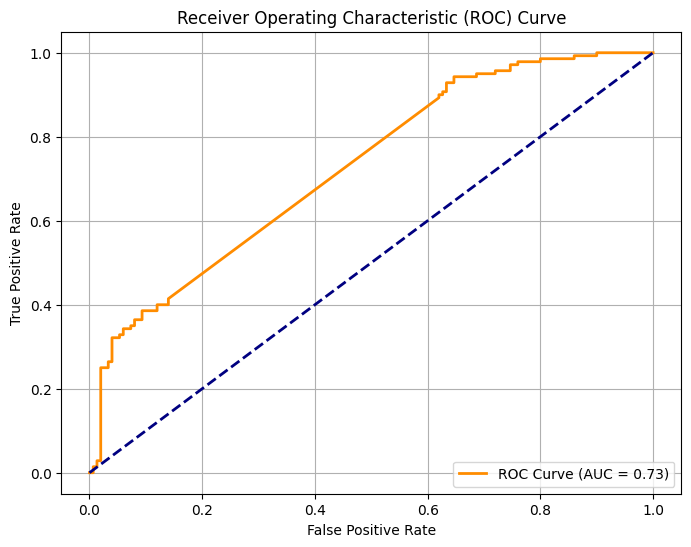

In [61]:
# Directory containing the pickle files
train_directory = "ProcessedData/Train"
# Load all training crime data
train_crime_data = load_crime_data_from_directory(train_directory)
# Assign each crime type to its respective variable
abuse_data = train_crime_data["abuse"]
arrest_data = train_crime_data["arrest"]
arson_data = train_crime_data["arson"]
assault_data = train_crime_data["assault"]
burglary_data = train_crime_data["burglary"]
explosion_data = train_crime_data["explosion"]
fighting_data = train_crime_data["fighting"]
roadaccidents_data = train_crime_data["roadaccidents"]
robbery_data = train_crime_data["robbery"]
shooting_data = train_crime_data["shooting"]
shoplifting_data = train_crime_data["shoplifting"]
stealing_data = train_crime_data["stealing"]
vandalism_data = train_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(train_crime_data)} crime types:")


# Combine all crime data into one list
all_train_crime_data = []
for crime_data in [
    abuse_data, arrest_data, arson_data, assault_data, burglary_data,
    explosion_data, fighting_data, roadaccidents_data, robbery_data,
    shooting_data, shoplifting_data, stealing_data, vandalism_data
]:
    all_train_crime_data.extend(crime_data)
# Dynamically generate crime labels (1 through 13)
crime_labels = set(range(1, 14))  # {1, 2, 3, ..., 13}
# Merge all crime labels into one class (1 for Crime, 0 for Normal)
train_binary_crime_data = merge_crime_labels(all_train_crime_data, crime_labels)

normal_data = pd.read_pickle("normal_data.pkl")
normal_data = normal_data.to_numpy()
normal_data = normal_data.tolist()

training_data = train_binary_crime_data + normal_data


# # Combine Normal and oversampled Crime data
# balanced_training_data = np.concatenate([normal_data, oversampled_crime_data], axis=0)
# random.shuffle(balanced_training_data)  # Shuffle the data for randomness
# # Create a dataset and DataLoader for the balanced training data
from sklearn.model_selection import train_test_split
# # Assuming `training_data` contains your full training dataset
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
# Print sizes for verification
print(f"Training set size: {len(train_data)}, Validation set size: {len(val_data)}")

train_dataset = TemporalVideoDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
# Create DataLoader for the validation set
val_dataset = TemporalVideoDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


from collections import Counter
import torch.nn as nn
# Assuming training_data contains tuples of (features, label)
class_counts = Counter([label for _, label in training_data])
print("Class Counts:", class_counts) # Example: {0: 1000, 1: 100, 2: 50, ...}
# Calculate class weights
total_samples = sum(class_counts.values())
class_weights = {label: total_samples / count for label, count in class_counts.items()}
print("Class Weights:", class_weights)
# Convert weights to a tensor for nn.CrossEntropyLoss
num_classes = len(class_counts) # Total number of classes
weighted_class_weights_tensor = torch.tensor(
[class_weights.get(i, 0) for i in range(num_classes)], dtype=torch.float
).to(device)

# Binary Classification Model
model_binary_batch_2_weighted = CausalTransformer(input_dim=512, num_heads=4, num_layers=4).to(device)
criterion = nn.CrossEntropyLoss(weight = weighted_class_weights_tensor)
optimizer = optim.Adam(model_binary_batch_2_weighted.parameters(), lr=1e-4)

train_with_validation(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model=model_binary_batch_2_weighted,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20,  # Set a higher max epoch since early stopping will stop it early
    patience=5  # Adjust patience based on your dataset
)

file_path = f"Models/binary_weighted_regular_batch_size_16.pth"
save_model(model_binary_batch_2_weighted, file_path)
print(f"weighted binary model with batch size 16 saved.")

# Directory containing the pickle files
test_directory = "ProcessedData/Test"
# Load all training crime data
test_crime_data = load_crime_data_from_directory(test_directory)
# Assign each crime type to its respective variable
test_abuse_data = test_crime_data["abuse"]
test_arrest_data = test_crime_data["arrest"]
test_arson_data = test_crime_data["arson"]
test_assault_data = test_crime_data["assault"]
test_burglary_data = test_crime_data["burglary"]
test_explosion_data = test_crime_data["explosion"]
test_fighting_data = test_crime_data["fighting"]
test_roadaccidents_data = test_crime_data["roadaccidents"]
test_robbery_data = test_crime_data["robbery"]
test_shooting_data = test_crime_data["shooting"]
test_shoplifting_data = test_crime_data["shoplifting"]
test_stealing_data = test_crime_data["stealing"]
test_vandalism_data = test_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(test_crime_data)} crime types:")

# Combine all crime data into one list
all_test_crime_data = []
for crime_data in [
    test_abuse_data, test_arrest_data, test_arson_data, test_assault_data, test_burglary_data,
    test_explosion_data, test_fighting_data, test_roadaccidents_data, test_robbery_data,
    test_shooting_data, test_shoplifting_data, test_stealing_data, test_vandalism_data
]:
    all_test_crime_data.extend(crime_data)
# Dynamically generate crime labels (1 through 13)
crime_labels = set(range(1, 14))  # {1, 2, 3, ..., 13}
# Merge all crime labels into one class (1 for Crime, 0 for Normal)
test_binary_crime_data = merge_crime_labels(all_test_crime_data, crime_labels)

test_normal_data = pd.read_pickle("normal_test_data.pkl")
test_normal_data = test_normal_data.to_numpy()
test_normal_data = test_normal_data.tolist()
test_data = test_normal_data + test_binary_crime_data

# Create dataset and dataloader 
test_dataset = TemporalVideoDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

weighted_binary_predictions_2, weighted_binary_true_labels_2, weighted_binary_probabilities_2 = evaluate_model(model_binary_batch_2_weighted, test_dataloader, device, threshold = 0.5)
compute_metrics(weighted_binary_predictions_2, weighted_binary_true_labels_2, weighted_binary_probabilities_2)

## Multiclass Model

Loading ProcessedData/Train\abuse_data.pkl...
Loading ProcessedData/Train\arrest_data.pkl...
Loading ProcessedData/Train\arson_data.pkl...
Loading ProcessedData/Train\assault_data.pkl...
Loading ProcessedData/Train\burglary_data.pkl...
Loading ProcessedData/Train\explosion_data.pkl...
Loading ProcessedData/Train\fighting_data.pkl...
Loading ProcessedData/Train\roadaccidents_data.pkl...
Loading ProcessedData/Train\robbery_data.pkl...
Loading ProcessedData/Train\shooting_data.pkl...
Loading ProcessedData/Train\shoplifting_data.pkl...
Loading ProcessedData/Train\stealing_data.pkl...
Loading ProcessedData/Train\vandalism_data.pkl...
Loaded 13 crime types:
Training set size: 1288, Validation set size: 322
Epoch 1/20, Training Loss: 1.7217
Epoch 1/20, Validation Loss: 2.2576
Validation loss improved. Saving the model...
Epoch 2/20, Training Loss: 1.3620
Epoch 2/20, Validation Loss: 2.2543
Validation loss improved. Saving the model...
Epoch 3/20, Training Loss: 1.1103
Epoch 3/20, Validation L

c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

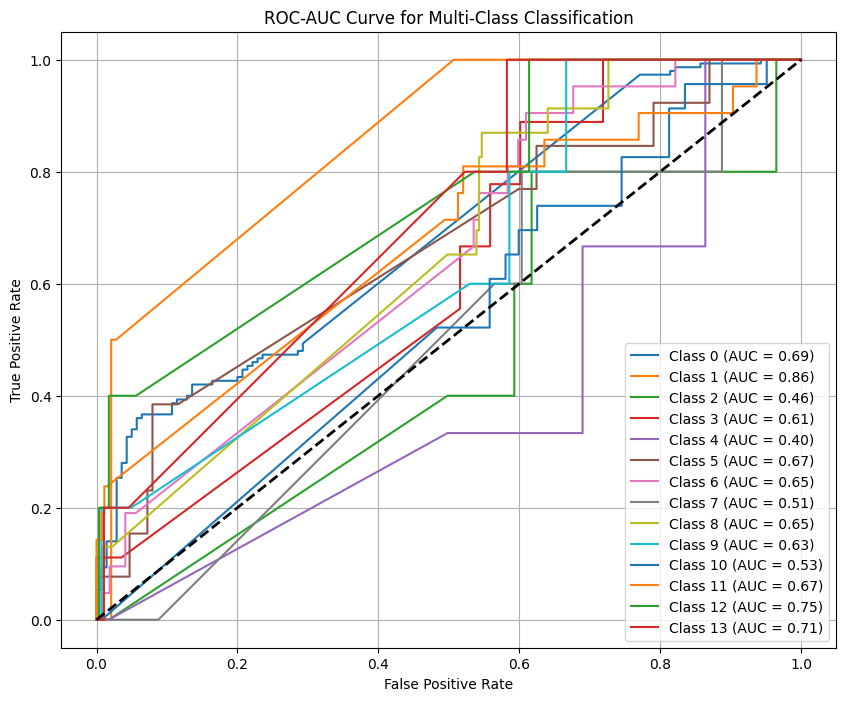

Class 0: ROC-AUC = 0.6888
Class 1: ROC-AUC = 0.8559
Class 2: ROC-AUC = 0.4618
Class 3: ROC-AUC = 0.6113
Class 4: ROC-AUC = 0.3961
Class 5: ROC-AUC = 0.6651
Class 6: ROC-AUC = 0.6461
Class 7: ROC-AUC = 0.5060
Class 8: ROC-AUC = 0.6548
Class 9: ROC-AUC = 0.6323
Class 10: ROC-AUC = 0.5318
Class 11: ROC-AUC = 0.6741
Class 12: ROC-AUC = 0.7544
Class 13: ROC-AUC = 0.7109


In [ ]:
# Directory containing the pickle files
train_directory = "ProcessedData/Train"
# Load all training crime data
train_crime_data = load_crime_data_from_directory(train_directory)
# Assign each crime type to its respective variable
abuse_data = train_crime_data["abuse"]
arrest_data = train_crime_data["arrest"]
arson_data = train_crime_data["arson"]
assault_data = train_crime_data["assault"]
burglary_data = train_crime_data["burglary"]
explosion_data = train_crime_data["explosion"]
fighting_data = train_crime_data["fighting"]
roadaccidents_data = train_crime_data["roadaccidents"]
robbery_data = train_crime_data["robbery"]
shooting_data = train_crime_data["shooting"]
shoplifting_data = train_crime_data["shoplifting"]
stealing_data = train_crime_data["stealing"]
vandalism_data = train_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(train_crime_data)} crime types:")


# Combine all crime data into one list
all_train_crime_data = []
for crime_data in [
    abuse_data, arrest_data, arson_data, assault_data, burglary_data,
    explosion_data, fighting_data, roadaccidents_data, robbery_data,
    shooting_data, shoplifting_data, stealing_data, vandalism_data
]:
    all_train_crime_data.extend(crime_data)


normal_data = pd.read_pickle("normal_data.pkl")
normal_data = normal_data.to_numpy()
normal_data = normal_data.tolist()

training_data = all_train_crime_data + normal_data


# # Combine Normal and oversampled Crime data
# balanced_training_data = np.concatenate([normal_data, oversampled_crime_data], axis=0)
# random.shuffle(balanced_training_data)  # Shuffle the data for randomness
# # Create a dataset and DataLoader for the balanced training data
from sklearn.model_selection import train_test_split
# # Assuming `training_data` contains your full training dataset
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
# Print sizes for verification
print(f"Training set size: {len(train_data)}, Validation set size: {len(val_data)}")

train_dataset = TemporalVideoDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
# Create DataLoader for the validation set
val_dataset = TemporalVideoDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


# Binary Classification Model
model_multiclass_batch_2 = CausalTransformerMultiClass(input_dim=512, num_heads=4, num_layers=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_multiclass_batch_2.parameters(), lr=1e-4)



train_with_validation(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model=model_multiclass_batch_2,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20,  # Set a higher max epoch since early stopping will stop it early
    patience=5  # Adjust patience based on your dataset
)

file_path = f"Models/multiclass_regular_batch_size_2.pth"
save_model(model_multiclass_batch_2, file_path)
print(f"Regular multiclass model with batch size 2 saved.")

# Directory containing the pickle files
test_directory = "ProcessedData/Test"
# Load all training crime data
test_crime_data = load_crime_data_from_directory(test_directory)
# Assign each crime type to its respective variable
test_abuse_data = test_crime_data["abuse"]
test_arrest_data = test_crime_data["arrest"]
test_arson_data = test_crime_data["arson"]
test_assault_data = test_crime_data["assault"]
test_burglary_data = test_crime_data["burglary"]
test_explosion_data = test_crime_data["explosion"]
test_fighting_data = test_crime_data["fighting"]
test_roadaccidents_data = test_crime_data["roadaccidents"]
test_robbery_data = test_crime_data["robbery"]
test_shooting_data = test_crime_data["shooting"]
test_shoplifting_data = test_crime_data["shoplifting"]
test_stealing_data = test_crime_data["stealing"]
test_vandalism_data = test_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(test_crime_data)} crime types:")

# Combine all crime data into one list
all_test_crime_data = []
for crime_data in [
    test_abuse_data, test_arrest_data, test_arson_data, test_assault_data, test_burglary_data,
    test_explosion_data, test_fighting_data, test_roadaccidents_data, test_robbery_data,
    test_shooting_data, test_shoplifting_data, test_stealing_data, test_vandalism_data
]:
    all_test_crime_data.extend(crime_data)

test_normal_data = pd.read_pickle("normal_test_data.pkl")
test_normal_data = test_normal_data.to_numpy()
test_normal_data = test_normal_data.tolist()
test_data = test_normal_data + all_test_crime_data

# Create dataset and dataloader 
test_dataset = TemporalVideoDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

multiclass_predictions_2, multiclass_true_labels_2, multiclass_probabilities_2 = evaluate_model_multiclass(model_multiclass_batch_2, test_dataloader, device)


In [50]:
model_multiclass_batch_2 = load_model(model_multiclass, "Models/multiclass_regular_batch_size_2.pth", device)

Model loaded from Models/multiclass_regular_batch_size_2.pth


C:\Users\mason\AppData\Local\Temp\ipykernel_9996\2974611989.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path, map_location=dev

In [51]:
# Directory containing the pickle files
test_directory = "ProcessedData/Test"
# Load all training crime data
test_crime_data = load_crime_data_from_directory(test_directory)
# Assign each crime type to its respective variable
test_abuse_data = test_crime_data["abuse"]
test_arrest_data = test_crime_data["arrest"]
test_arson_data = test_crime_data["arson"]
test_assault_data = test_crime_data["assault"]
test_burglary_data = test_crime_data["burglary"]
test_explosion_data = test_crime_data["explosion"]
test_fighting_data = test_crime_data["fighting"]
test_roadaccidents_data = test_crime_data["roadaccidents"]
test_robbery_data = test_crime_data["robbery"]
test_shooting_data = test_crime_data["shooting"]
test_shoplifting_data = test_crime_data["shoplifting"]
test_stealing_data = test_crime_data["stealing"]
test_vandalism_data = test_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(test_crime_data)} crime types:")

# Combine all crime data into one list
all_test_crime_data = []
for crime_data in [
    test_abuse_data, test_arrest_data, test_arson_data, test_assault_data, test_burglary_data,
    test_explosion_data, test_fighting_data, test_roadaccidents_data, test_robbery_data,
    test_shooting_data, test_shoplifting_data, test_stealing_data, test_vandalism_data
]:
    all_test_crime_data.extend(crime_data)

test_normal_data = pd.read_pickle("normal_test_data.pkl")
test_normal_data = test_normal_data.to_numpy()
test_normal_data = test_normal_data.tolist()
test_data = test_normal_data + all_test_crime_data

# Create dataset and dataloader 
test_dataset = TemporalVideoDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

multiclass_predictions_2, multiclass_true_labels_2, multiclass_probabilities_2 = evaluate_model_multiclass(model_multiclass_batch_2, test_dataloader, device)

Loading ProcessedData/Test\abuse_data.pkl...
Loading ProcessedData/Test\arrest_data.pkl...
Loading ProcessedData/Test\arson_data.pkl...
Loading ProcessedData/Test\assault_data.pkl...
Loading ProcessedData/Test\burglary_data.pkl...
Loading ProcessedData/Test\explosion_data.pkl...
Loading ProcessedData/Test\fighting_data.pkl...
Loading ProcessedData/Test\roadaccidents_data.pkl...
Loading ProcessedData/Test\robbery_data.pkl...
Loading ProcessedData/Test\shooting_data.pkl...
Loading ProcessedData/Test\shoplifting_data.pkl...
Loading ProcessedData/Test\stealing_data.pkl...
Loading ProcessedData/Test\vandalism_data.pkl...
Loaded 13 crime types:


c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\NestedTensorImpl.cpp:180.)
  output = torch._nested_tensor_from_mask(


Confusion Matrix:
 [[68  0  3  0  0  1  0  0  1 73  1  0  1  2]
 [ 0  0  1  0  0  0  0  0  0  1  0  0  0  0]
 [ 2  0  0  0  0  0  0  1  0  2  0  0  0  0]
 [ 1  0  2  1  0  0  0  0  0  4  0  0  1  0]
 [ 0  0  0  0  0  0  0  2  0  1  0  0  0  0]
 [ 4  0  0  1  0  0  0  1  0  5  0  0  1  1]
 [ 4  0  1  0  0  0  0  1  0 11  0  0  1  3]
 [ 2  0  0  0  0  0  0  0  0  3  0  0  0  0]
 [ 7  0  3  0  0  1  0  0  0 12  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  2  1  0  0  0]
 [ 3  0  1  0  0  0  0  2  0 12  1  0  2  2]
 [ 5  0  0  0  0  0  0  0  0 13  0  1  1  1]
 [ 1  0  0  0  0  0  0  0  0  2  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  3  0  0  1  1]]

Classification Report:
                precision    recall  f1-score   support

       normal       0.69      0.45      0.55       150
        abuse       0.00      0.00      0.00         2
       arrest       0.00      0.00      0.00         5
        arson       0.50      0.11      0.18         9
      assault       0.00      0.00      0.00     

c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

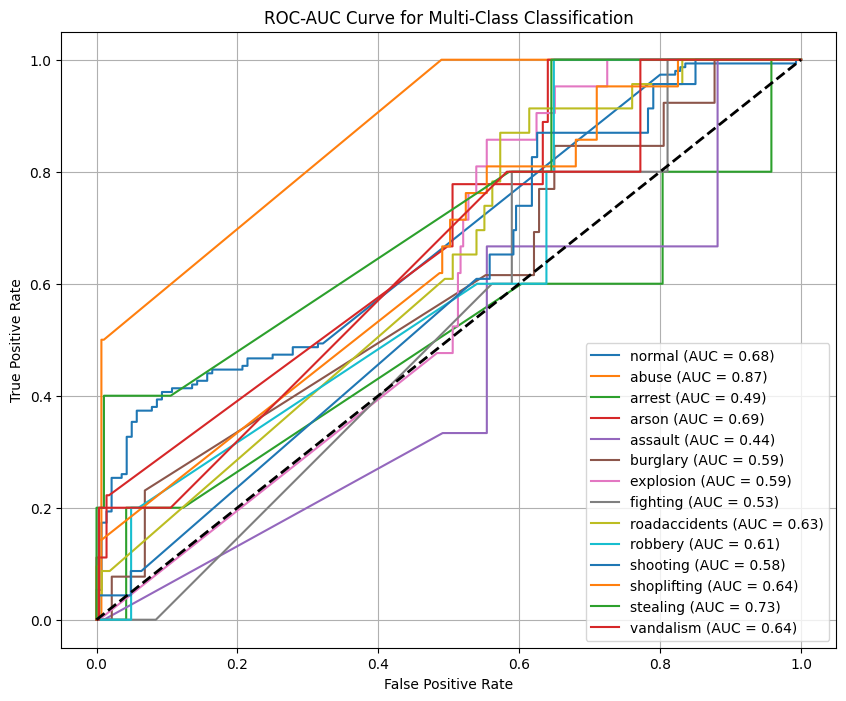

normal: ROC-AUC = 0.6793
abuse: ROC-AUC = 0.8715
arrest: ROC-AUC = 0.4940
arson: ROC-AUC = 0.6860
assault: ROC-AUC = 0.4379
burglary: ROC-AUC = 0.5929
explosion: ROC-AUC = 0.5893
fighting: ROC-AUC = 0.5263
roadaccidents: ROC-AUC = 0.6261
robbery: ROC-AUC = 0.6126
shooting: ROC-AUC = 0.5782
shoplifting: ROC-AUC = 0.6442
stealing: ROC-AUC = 0.7305
vandalism: ROC-AUC = 0.6386


In [ ]:
# Define the mapping of class numbers to category names
class_to_category = {
    0: "normal",
    1: "abuse",
    2: "arrest",
    3: "arson",
    4: "assault",
    5: "burglary",
    6: "explosion",
    7: "fighting",
    8: "roadaccidents",
    9: "robbery",
    10: "shooting",
    11: "shoplifting",
    12: "stealing",
    13: "vandalism"
}



# Updated function call
compute_metrics_multiclass(
    predictions=multiclass_predictions_2,
    true_labels=multiclass_true_labels_2,
    probabilities=multiclass_probabilities_2,
    num_classes=14,
    class_to_category=class_to_category
)

## Weights Multiclass

In [ ]:
# Directory containing the pickle files
train_directory = "ProcessedData/Train"
# Load all training crime data
train_crime_data = load_crime_data_from_directory(train_directory)
# Assign each crime type to its respective variable
abuse_data = train_crime_data["abuse"]
arrest_data = train_crime_data["arrest"]
arson_data = train_crime_data["arson"]
assault_data = train_crime_data["assault"]
burglary_data = train_crime_data["burglary"]
explosion_data = train_crime_data["explosion"]
fighting_data = train_crime_data["fighting"]
roadaccidents_data = train_crime_data["roadaccidents"]
robbery_data = train_crime_data["robbery"]
shooting_data = train_crime_data["shooting"]
shoplifting_data = train_crime_data["shoplifting"]
stealing_data = train_crime_data["stealing"]
vandalism_data = train_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(train_crime_data)} crime types:")


# Combine all crime data into one list
all_train_crime_data = []
for crime_data in [
    abuse_data, arrest_data, arson_data, assault_data, burglary_data,
    explosion_data, fighting_data, roadaccidents_data, robbery_data,
    shooting_data, shoplifting_data, stealing_data, vandalism_data
]:
    all_train_crime_data.extend(crime_data)


normal_data = pd.read_pickle("normal_data.pkl")
normal_data = normal_data.to_numpy()
normal_data = normal_data.tolist()

training_data = all_train_crime_data + normal_data


# # Combine Normal and oversampled Crime data
# balanced_training_data = np.concatenate([normal_data, oversampled_crime_data], axis=0)
# random.shuffle(balanced_training_data)  # Shuffle the data for randomness
# # Create a dataset and DataLoader for the balanced training data
from sklearn.model_selection import train_test_split
# # Assuming `training_data` contains your full training dataset
train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=42)
# Print sizes for verification
print(f"Training set size: {len(train_data)}, Validation set size: {len(val_data)}")

train_dataset = TemporalVideoDataset(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
# Create DataLoader for the validation set
val_dataset = TemporalVideoDataset(val_data)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


from collections import Counter
import torch.nn as nn
# Assuming training_data contains tuples of (features, label)
class_counts = Counter([label for _, label in training_data])
print("Class Counts:", class_counts) # Example: {0: 1000, 1: 100, 2: 50, ...}
# Calculate class weights
total_samples = sum(class_counts.values())
class_weights = {label: total_samples / count for label, count in class_counts.items()}
print("Class Weights:", class_weights)
# Convert weights to a tensor for nn.CrossEntropyLoss
num_classes = len(class_counts) # Total number of classes
class_weights_tensor = torch.tensor([class_weights.get(i, 0) for i in range(num_classes)], dtype=torch.float).to(device)

# Binary Classification Model
model_multiclass_batch_2_weighted = CausalTransformerMultiClass(input_dim=512, num_heads=4, num_layers=4).to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights_tensor)
optimizer = optim.Adam(model_multiclass_batch_2_weighted.parameters(), lr=1e-4)



train_with_validation(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    model=model_multiclass_batch_2_weighted,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=20,  # Set a higher max epoch since early stopping will stop it early
    patience=5  # Adjust patience based on your dataset
)

file_path = f"Models/multiclass_weighted_regular_batch_size_2.pth"
save_model(model_multiclass_batch_2_weighted, file_path)
print(f"weighted multiclass model with batch size 2 saved.")

# Directory containing the pickle files
test_directory = "ProcessedData/Test"
# Load all training crime data
test_crime_data = load_crime_data_from_directory(test_directory)
# Assign each crime type to its respective variable
test_abuse_data = test_crime_data["abuse"]
test_arrest_data = test_crime_data["arrest"]
test_arson_data = test_crime_data["arson"]
test_assault_data = test_crime_data["assault"]
test_burglary_data = test_crime_data["burglary"]
test_explosion_data = test_crime_data["explosion"]
test_fighting_data = test_crime_data["fighting"]
test_roadaccidents_data = test_crime_data["roadaccidents"]
test_robbery_data = test_crime_data["robbery"]
test_shooting_data = test_crime_data["shooting"]
test_shoplifting_data = test_crime_data["shoplifting"]
test_stealing_data = test_crime_data["stealing"]
test_vandalism_data = test_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(test_crime_data)} crime types:")

# Combine all crime data into one list
all_test_crime_data = []
for crime_data in [
    test_abuse_data, test_arrest_data, test_arson_data, test_assault_data, test_burglary_data,
    test_explosion_data, test_fighting_data, test_roadaccidents_data, test_robbery_data,
    test_shooting_data, test_shoplifting_data, test_stealing_data, test_vandalism_data
]:
    all_test_crime_data.extend(crime_data)

test_normal_data = pd.read_pickle("normal_test_data.pkl")
test_normal_data = test_normal_data.to_numpy()
test_normal_data = test_normal_data.tolist()
test_data = test_normal_data + all_test_crime_data

# Create dataset and dataloader 
test_dataset = TemporalVideoDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

weighted_multiclass_predictions_2, weighted_multiclass_true_labels_2, weighted_multiclass_probabilities_2 = evaluate_model_multiclass(model_multiclass_batch_2_weighted, test_dataloader, device)
# compute_metrics_multiclass(weighted_multiclass_predictions_2, weighted_multiclass_true_labels_2, weighted_multiclass_probabilities_2)

Loading ProcessedData/Train\abuse_data.pkl...
Loading ProcessedData/Train\arrest_data.pkl...
Loading ProcessedData/Train\arson_data.pkl...
Loading ProcessedData/Train\assault_data.pkl...
Loading ProcessedData/Train\burglary_data.pkl...
Loading ProcessedData/Train\explosion_data.pkl...
Loading ProcessedData/Train\fighting_data.pkl...
Loading ProcessedData/Train\roadaccidents_data.pkl...
Loading ProcessedData/Train\robbery_data.pkl...
Loading ProcessedData/Train\shooting_data.pkl...
Loading ProcessedData/Train\shoplifting_data.pkl...
Loading ProcessedData/Train\stealing_data.pkl...
Loading ProcessedData/Train\vandalism_data.pkl...
Loaded 13 crime types:
Training set size: 1288, Validation set size: 322
Class Counts: Counter({0: 800, 9: 145, 8: 127, 12: 95, 5: 87, 1: 48, 4: 47, 2: 45, 7: 45, 13: 45, 3: 41, 6: 29, 11: 29, 10: 27})
Class Weights: {1: 33.541666666666664, 2: 35.77777777777778, 3: 39.26829268292683, 4: 34.255319148936174, 5: 18.50574712643678, 6: 55.51724137931034, 7: 35.77777

In [55]:
model_multiclass_batch_2_weighted = load_model(model_multiclass, "Models/multiclass_weighted_regular_batch_size_2.pth", device)

Model loaded from Models/multiclass_weighted_regular_batch_size_2.pth


C:\Users\mason\AppData\Local\Temp\ipykernel_9996\2974611989.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(file_path, map_location=dev

In [56]:
# Directory containing the pickle files
test_directory = "ProcessedData/Test"
# Load all training crime data
test_crime_data = load_crime_data_from_directory(test_directory)
# Assign each crime type to its respective variable
test_abuse_data = test_crime_data["abuse"]
test_arrest_data = test_crime_data["arrest"]
test_arson_data = test_crime_data["arson"]
test_assault_data = test_crime_data["assault"]
test_burglary_data = test_crime_data["burglary"]
test_explosion_data = test_crime_data["explosion"]
test_fighting_data = test_crime_data["fighting"]
test_roadaccidents_data = test_crime_data["roadaccidents"]
test_robbery_data = test_crime_data["robbery"]
test_shooting_data = test_crime_data["shooting"]
test_shoplifting_data = test_crime_data["shoplifting"]
test_stealing_data = test_crime_data["stealing"]
test_vandalism_data = test_crime_data["vandalism"]
# Example to verify the data
print(f"Loaded {len(test_crime_data)} crime types:")

# Combine all crime data into one list
all_test_crime_data = []
for crime_data in [
    test_abuse_data, test_arrest_data, test_arson_data, test_assault_data, test_burglary_data,
    test_explosion_data, test_fighting_data, test_roadaccidents_data, test_robbery_data,
    test_shooting_data, test_shoplifting_data, test_stealing_data, test_vandalism_data
]:
    all_test_crime_data.extend(crime_data)

test_normal_data = pd.read_pickle("normal_test_data.pkl")
test_normal_data = test_normal_data.to_numpy()
test_normal_data = test_normal_data.tolist()
test_data = test_normal_data + all_test_crime_data

# Create dataset and dataloader 
test_dataset = TemporalVideoDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

weighted_multiclass_predictions_2, weighted_multiclass_true_labels_2, weighted_multiclass_probabilities_2 = evaluate_model_multiclass(model_multiclass_batch_2_weighted, test_dataloader, device)
# compute_metrics_multiclass(weighted_multiclass_predictions_2, weighted_multiclass_true_labels_2, weighted_multiclass_probabilities_2)

Loading ProcessedData/Test\abuse_data.pkl...
Loading ProcessedData/Test\arrest_data.pkl...
Loading ProcessedData/Test\arson_data.pkl...
Loading ProcessedData/Test\assault_data.pkl...
Loading ProcessedData/Test\burglary_data.pkl...
Loading ProcessedData/Test\explosion_data.pkl...
Loading ProcessedData/Test\fighting_data.pkl...
Loading ProcessedData/Test\roadaccidents_data.pkl...
Loading ProcessedData/Test\robbery_data.pkl...
Loading ProcessedData/Test\shooting_data.pkl...
Loading ProcessedData/Test\shoplifting_data.pkl...
Loading ProcessedData/Test\stealing_data.pkl...
Loading ProcessedData/Test\vandalism_data.pkl...
Loaded 13 crime types:


Confusion Matrix:
 [[58  1  4  0  2  6  0 72  1  1  0  3  2  0]
 [ 1  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  3  0  0  0  0  0  0]
 [ 1  0  1  1  0  1  1  4  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  2  1  0  0  0  5  0  2  0  1  1  1]
 [ 0  1  1  0  1  0  1 11  5  0  0  1  0  0]
 [ 1  0  0  0  1  0  0  3  0  0  0  0  0  0]
 [ 3  0  2  0  3  1  1 12  1  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  2  0  1  0  1  0  0]
 [ 3  1  3  0  0  0  0 13  1  0  0  0  2  0]
 [ 3  0  0  0  1  0  0 10  0  3  0  4  0  0]
 [ 0  0  1  0  0  1  0  2  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  1  1  0]]

Classification Report:
                precision    recall  f1-score   support

       normal       0.82      0.39      0.52       150
        abuse       0.00      0.00      0.00         2
       arrest       0.06      0.20      0.09         5
        arson       0.50      0.11      0.18         9
      assault       0.00      0.00      0.00     

c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mason\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

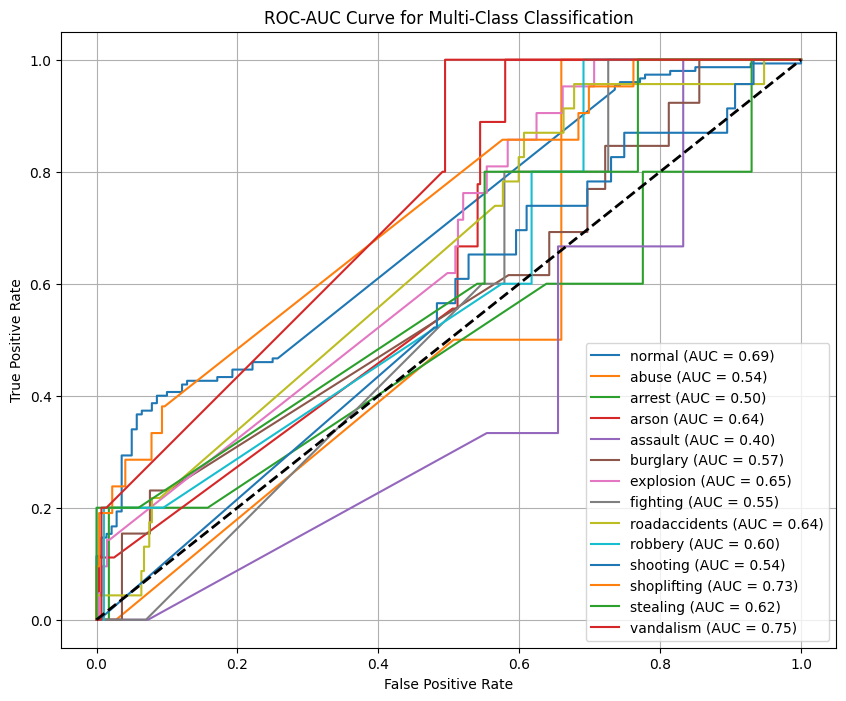

normal: ROC-AUC = 0.6947
abuse: ROC-AUC = 0.5365
arrest: ROC-AUC = 0.4961
arson: ROC-AUC = 0.6398
assault: ROC-AUC = 0.3995
burglary: ROC-AUC = 0.5698
explosion: ROC-AUC = 0.6532
fighting: ROC-AUC = 0.5537
roadaccidents: ROC-AUC = 0.6396
robbery: ROC-AUC = 0.6021
shooting: ROC-AUC = 0.5419
shoplifting: ROC-AUC = 0.7261
stealing: ROC-AUC = 0.6161
vandalism: ROC-AUC = 0.7481


In [57]:
# Updated function call
compute_metrics_multiclass(
    predictions=weighted_multiclass_predictions_2,
    true_labels=weighted_multiclass_true_labels_2,
    probabilities=weighted_multiclass_probabilities_2,
    num_classes=14,
    class_to_category=class_to_category
)